# CISA KVE EPSS Data Analyis 

In [1]:
import pandas as pd
import json
import requests
import os
import glob
import numpy as np

In [2]:
cisa_df = pd.read_csv("https://www.cisa.gov/sites/default/files/csv/known_exploited_vulnerabilities.csv")
cisa_df = cisa_df
cisa_df.columns = cisa_df.columns.str.strip("\u200b")
cisa_df = cisa_df.rename(columns={"cveID": "CVE", "shortDescription" : "Description", "dateAdded" : "Date"})

In [3]:
epss = pd.read_csv('epss_scores-current.csv', skiprows=1)
epss = epss.rename(columns={"cve": "CVE", "epss" : "EPSS", "percentile" : "EPSS Percentile"})

In [4]:
row_accumulator = []
for filename in glob.glob('nvdcve-2.0-*.json'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data['vulnerabilities']:
            cve = entry['cve']['id']
            try:
                base_score = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['baseScore']
            except KeyError:
                base_score = '0.0'
            new_row = { 
                'CVE': cve, 
                'CVSS3': base_score,
            }
            row_accumulator.append(new_row)
        nvd = pd.DataFrame(row_accumulator)
        
nvd['CVSS3'] = pd.to_numeric(nvd['CVSS3']);
nvd['CVSS3'] = nvd['CVSS3'].replace(0, np.nan);       

In [5]:
epss_kev = pd.merge(cisa_df, epss, left_on='CVE', right_on='CVE')
epss_kev_nvd =  pd.merge(epss_kev, nvd, left_on='CVE', right_on='CVE')
epss_kev_nvd =  epss_kev_nvd[["CVE", "CVSS3", "EPSS", "EPSS Percentile", "Description", "Date"]]

## CISA KEV Score Scatter Plot

/opt/hostedtoolcache/Python/3.10.19/x64/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1351: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


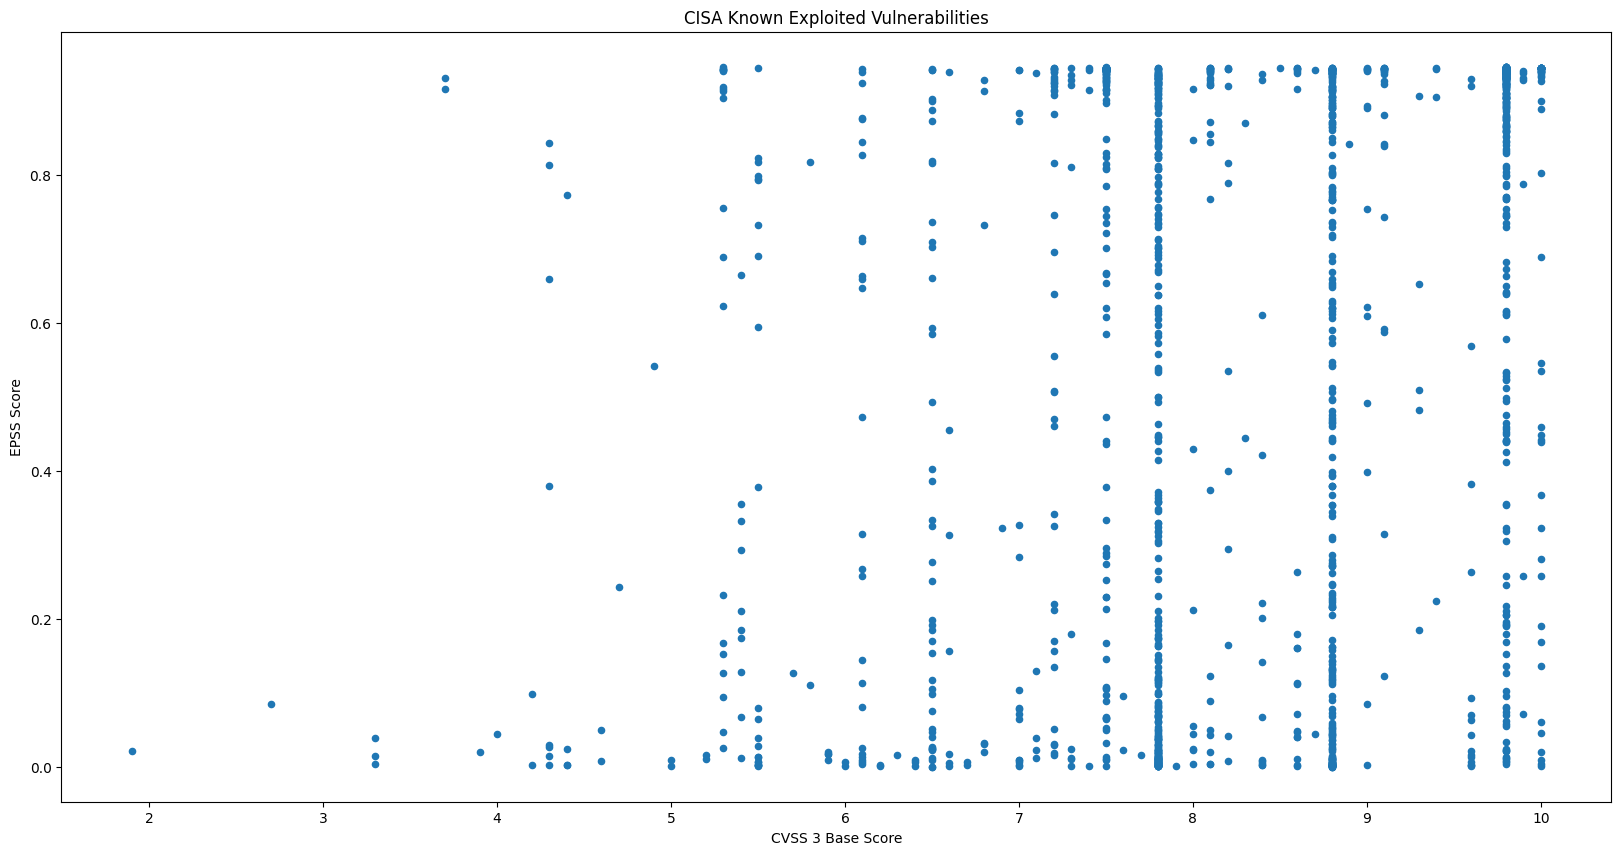

In [6]:
ax = epss_kev_nvd.plot.scatter(x='CVSS3',
                     y='EPSS',
                     colormap='jet',
                     figsize=(20, 10),
                     title='CISA Known Exploited Vulnerabilities');
ax.set_xlabel("CVSS 3 Base Score");
ax.set_ylabel("EPSS Score");
ax.figure.savefig('epss_kev_nvd.png');

## Export to CSV

In [7]:
epss_kev_nvd.to_csv("epss_kev_nvd.csv", index=False)
epss_kev_nvd.head(10)

,CVE,CVSS3,EPSS,EPSS Percentile,Description,Date
0,CVE-2025-14733,NaN,0.00209,0.43443,WatchGuard Fireware OS iked process contains a...,2025-12-19
1,CVE-2025-59374,9.8,0.30457,0.96528,ASUS Live Update contains an embedded maliciou...,2025-12-17
2,CVE-2025-40602,6.6,0.01709,0.81862,SonicWall SMA1000 contains a missing authoriza...,2025-12-17
3,CVE-2025-20393,10.0,0.04563,0.88818,"Cisco Secure Email Gateway, Secure Email, Asyn...",2025-12-17
4,CVE-2025-59718,9.8,0.05574,0.89972,"Fortinet FortiOS, FortiSwitchMaster, FortiProx...",2025-12-16
5,CVE-2025-14611,9.8,0.32270,0.96668,Gladinet CentreStack and TrioFox contain a har...,2025-12-15
6,CVE-2025-43529,8.8,0.00100,0.28587,"Apple iOS, iPadOS, macOS, and other Apple prod...",2025-12-15
7,CVE-2018-4063,8.8,0.00934,0.75575,Sierra Wireless AirLink ALEOS contains an unre...,2025-12-12
8,CVE-2025-14174,8.8,0.00530,0.66559,Google Chromium contains an out of bounds memo...,2025-12-12
9,CVE-2025-58360,8.2,0.81540,0.99138,OSGeo GeoServer contains an improper restricti...,2025-12-11
